# Data Profiling
This notebook shows a preliminary data exploration, in terms of image's shapes, ratios, resolutions, brightness and saturations.

## Setup
Execute this cell before the other ones.

In [1]:
import os
import sys
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
sys.path.append(str(Path("../src").resolve()))
from config import *

def load_dataframe():
    '''
    Load the main dataframe that will contain for every image the following informations:
    - ratio = width/height
    - shape = {Square, Horizontal Rectangle, Vertical Rectangle}
    - resolution = {High, Low}
    - brightness_mean: The mean of the brightness of the image, when converted to HSV
    - saturation_mean: The mean of the saturation of the image, when converted to HSV
    '''
    data = []
    for file in os.listdir(os.path.join(ROOT_DIRECTORY_FROM_NOTEBOOKS, IMAGES_DATA_DIRECTORY)):
        if file.endswith(tuple(IMAGES_DATA_EXTENSIONS + [ext.upper() for ext in IMAGES_DATA_EXTENSIONS])):

            img = Image.open(os.path.join(ROOT_DIRECTORY_FROM_NOTEBOOKS, IMAGES_DATA_DIRECTORY, file)).convert("RGB")
            width, height = img.size
            ratio = width / height

            if 0.95 <= ratio <= 1.05:
                shape = "Square"
            elif ratio > 1.05:
                shape = "Horizontal Rectangle"
            else:
                shape = "Vertical Rectangle"

            # 640 x 640 is the input dimension of YOLO
            # if max(width, height) > 640, that means the image has to be downscaled for YOLO (no interpolation)
            # if max(width, height) < 640, that means the image has to be upscaled for YOLO (interpolation)
            # interpolation might bring some noise to informations
            if max(width, height) >= 640:
                resolution = "High"
            else:
                resolution = "Low"

            # convert to HSV to find brightness and saturation means
            hsv_img = img.convert("HSV")
            h, s, v = hsv_img.split()
            brightness_mean = np.array(v).mean()
            saturation_mean = np.array(s).mean()

            data.append({
                "filename": file,
                "ratio": ratio,
                "shape": shape,
                "resolution": resolution,
                "brightness_mean": brightness_mean,
                "saturation_mean": saturation_mean
            })

    return pd.DataFrame(data)

df = load_dataframe()


## Shape Analysis
Note that an image is considered a square when its ratio (width/height) is between 0.95 and 1.05 (not necessarily 1.0).

**Warning:** Some image's shapes are classified as vertical rectangles, but their content might be a square or an horizontal rectangle, because of paddings.<br>
Keep in mind, though, that the number of this type of images is low compared to the number of vertical rectangles.

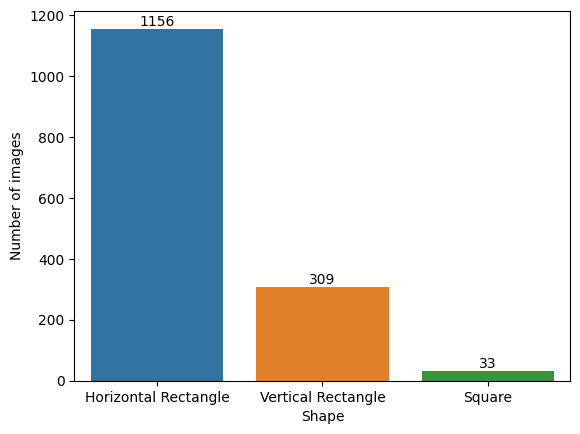

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x="shape", data=df, hue="shape")

for p in ax.patches:
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=p.get_height() + 10,
        s=int(p.get_height()),
        ha='center'
    )

plt.xlabel("Shape")
plt.ylabel("Number of images")
plt.show()


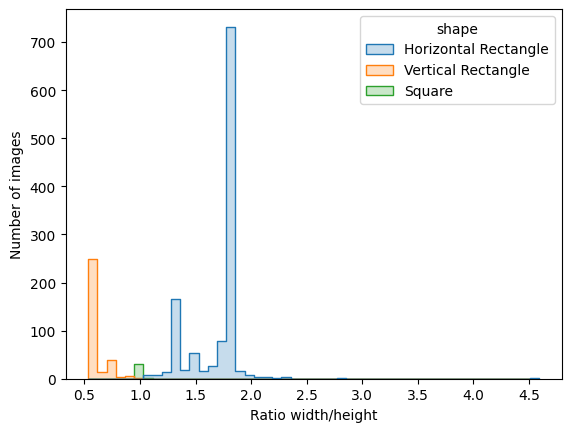

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=df, x="ratio", hue="shape", element="step", stat="count")
plt.xlabel("Ratio width/height")
plt.ylabel("Number of images")
plt.show()

# Resolution Analysis
An image has high resolution when its max length side is greater than 640, since an image with that dimension is downscaled for YOLO.

We need to discriminate beetween images that are downscaled and images that are upscaled, because the upscaled ones require interpolation,<br>
that might bring some noise, artifacts or loss of informations.

**Warning:** Some image were captured with full screen screenshots, so their resolutions are classified as high, even though there might have been interpolation to achieve full screen size.<br>
So these type of images are wrongly classified with high resolution, but in the worst case scenario they are 360 in total (the number of images called "Screenshot (i)"), and so there is still an imbalance between high and low resolution's images like before.

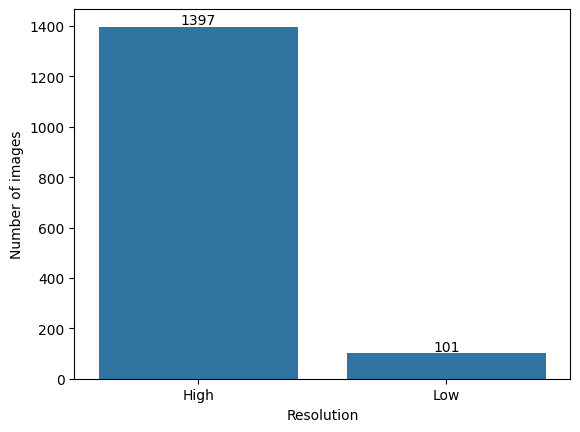

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x="resolution", data=df)

for p in ax.patches:
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=p.get_height() + 10,
        s=int(p.get_height()),
        ha='center'
    )

plt.xlabel("Resolution")
plt.ylabel("Number of images")
plt.show()

# Brightness and Saturation Analysis

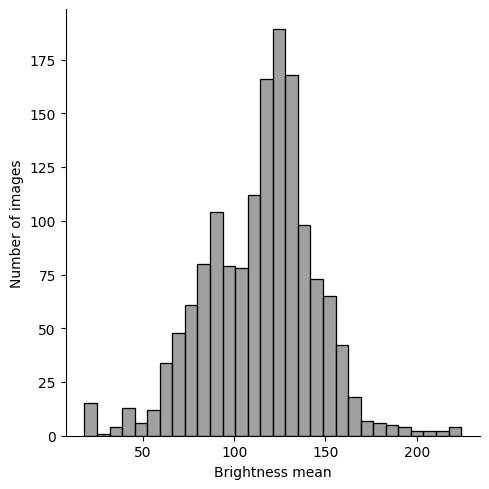

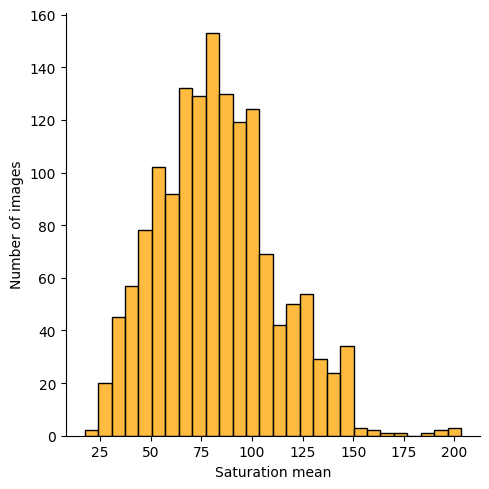

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(df["brightness_mean"], color="gray")
plt.xlabel("Brightness mean")
plt.ylabel("Number of images")
plt.show()

sns.displot(df["saturation_mean"], color="orange")
plt.xlabel("Saturation mean")
plt.ylabel("Number of images")
plt.show()
